<p style="background:#484E6E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> Lending Club</b><br>
    <br>Exploratory Data Analysis - Models 02 and 03<br><br> 
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 3: Unsupervised Learning & Hyperparameter Tuning<br>
Author : Renato Mariano</p>

<h1 style="color:#484E6E">Introduction </h1>

This data science project aims at automating lending decisions for LendingClub. It is a series of notebooks starting by 01_Data_Sampling_LendingClub.

**Specific Objective**:
1. Build a machine learning **model to classify loans as accepted or rejected**.

2. **Predict the loan grade**.

3. **Predict the loan subgrade and interest rate**.

<h2 style="color:#484E6E">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import gc
from rapidfuzz import process

from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#484E6E">Exploratory Data Analysis</h1>

<h2 style="color:#484E6E">Initial Exploration</h2>

As explained, the sampling of the dataset was made in a different notebook. In this notebook, some null rows were dropped before separation of the dataset.

Here we will dive into the big accepted dataframe and build up knowledge on this data in order to proceed to our next modeling tasks.

In [3]:
start = time()
df = pd.read_csv("data/exported/accepted_train.csv", skiprows=lambda x: x % 4)
end = time()
print(f"Read accepted train with pandas: {end-start:.3f}sec\n")
print(f"The shape of the data is: {df.shape}\n")
df.head(5)

Read accepted train with pandas: 8.322sec

The shape of the data is: (226066, 151)



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,94336377,NaN,35000.000,35000.000,35000.000,60 months,10.490,752.120,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,94102454,NaN,28000.000,28000.000,28000.000,36 months,14.990,970.500,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,39339501,NaN,20000.000,20000.000,20000.000,36 months,6.490,612.890,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,70996527,NaN,20000.000,20000.000,20000.000,60 months,14.460,470.150,C,C4,...,NaN,NaN,Cash,Y,Jan-2019,COMPLETE,Nov-2017,8003.000,50.000,14.000
4,135424479,NaN,20000.000,20000.000,20000.000,36 months,12.130,665.530,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pd.set_option("display.max_rows", None)
percent_missing = (df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
percent_missing

member_id                                    100.000
orig_projected_additional_accrued_interest    99.605
hardship_end_date                             99.507
hardship_start_date                           99.507
hardship_type                                 99.507
hardship_reason                               99.507
hardship_status                               99.507
deferral_term                                 99.507
hardship_last_payment_amount                  99.507
hardship_payoff_balance_amount                99.507
hardship_loan_status                          99.507
hardship_dpd                                  99.507
hardship_length                               99.507
payment_plan_start_date                       99.507
hardship_amount                               99.507
settlement_term                               98.467
debt_settlement_flag_date                     98.467
settlement_status                             98.467
settlement_date                               

In [5]:
pd.set_option('display.max_rows', 50) 

As we can see, some features are full of no information. Let's visualize it graphically.

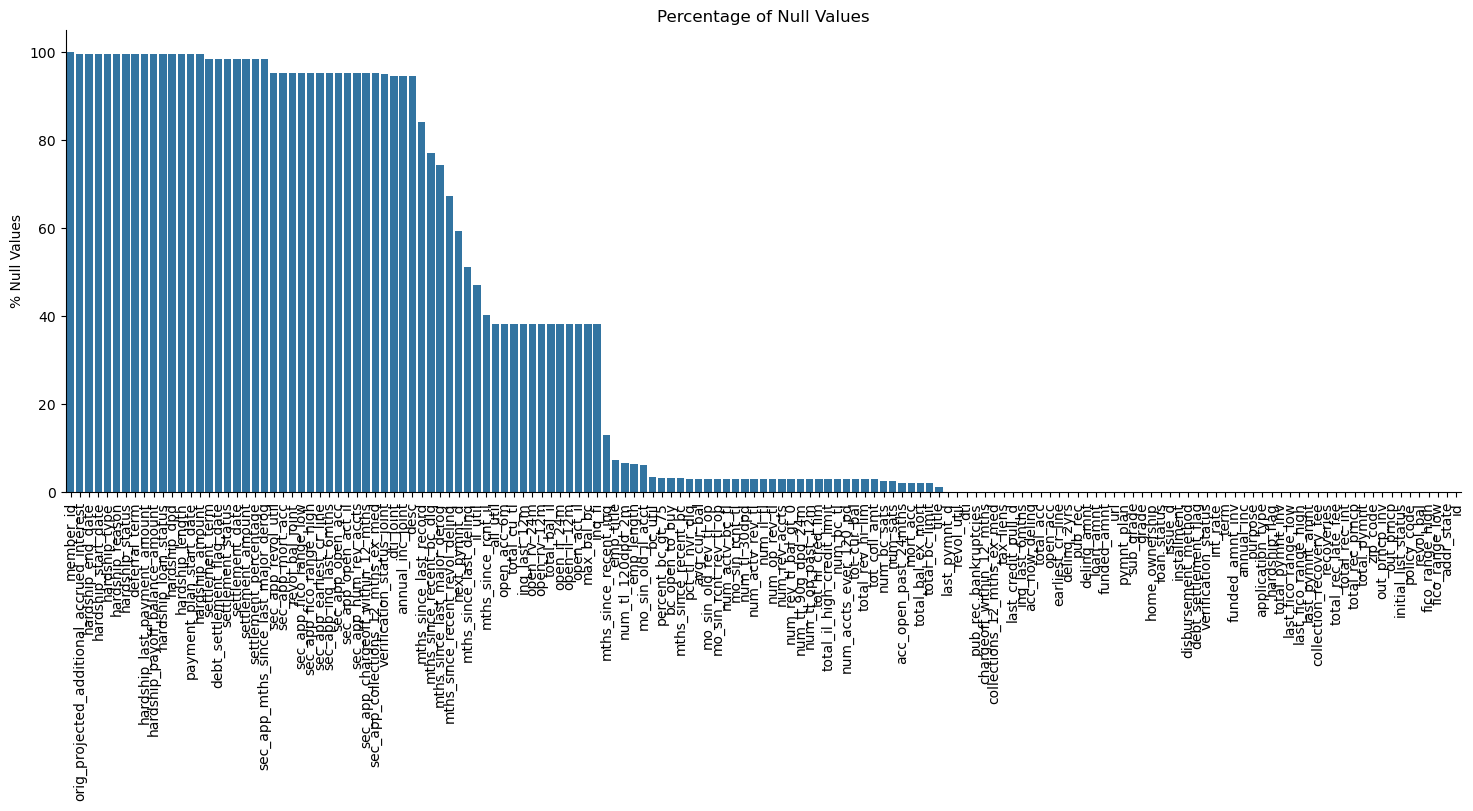

In [6]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(y=percent_missing, x=percent_missing.index, ax=ax)
ax.set(ylabel="% Null Values", xlabel="", title="Percentage of Null Values")
sns.despine()
plt.xticks(rotation=90);

On columns with more than 30% null values, any process of filling this values would bring too much incertainty to our model, so these features will be dropped.

Both imputation procedures and the drop of these columns will take place in our pipeline in the next notebook. For now, let's drop these columns for a faster evaluation.

In [7]:
keep_cols = percent_missing[percent_missing<30].index

df = pd.read_csv("data/exported/accepted_train.csv", usecols=keep_cols)
print(f"The shape of the data without columns with more than 30% null values is: {df.shape}\n")

The shape of the data without columns with more than 30% null values is: (904267, 93)



We are now left with a dataframe with 93 features out of 151.

We can select the object columns and numeric columns.

In [8]:
num_feats = df.select_dtypes(include='number').columns
cat_feats = df.select_dtypes(include='object').columns

In [9]:
df[cat_feats].nunique(axis=0)

term                         2
grade                        7
sub_grade                   35
emp_title               251067
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
loan_status                  9
pymnt_plan                   2
url                     904267
purpose                     14
title                    28845
zip_code                   925
addr_state                  51
earliest_cr_line           728
initial_list_status          2
last_pymnt_d               136
last_credit_pull_d         138
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

Here above are 2 of our targets (loan grade and subgrade).

Some of these categorical features and some numerical features will not provide important information to our model and therefore will be dropped.

In [10]:
df.drop(['id', 'emp_title', 'url', 'zip_code', 'title', 'policy_code'], axis=1, inplace=True)

Due to our large dataset, we can drop the rest of the rows that still present NA values.

In [11]:
df_reduced = df.dropna()
print(df_reduced.shape[0]/df.shape[0])

0.7448961424004193


Our data maintains 74% of the rows, which is still a lot of data.

In [12]:
del df
gc.collect()
df_reduced.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,27450.000,27450.000,27450.000,60 months,13.980,638.430,C,C3,10+ years,MORTGAGE,...,0.000,0.000,0.000,247197.000,20542.000,58500.000,25000.000,N,Cash,N
1,17400.000,17400.000,17400.000,36 months,6.030,529.580,A,A1,1 year,RENT,...,25.000,0.000,0.000,171280.000,135319.000,22500.000,140268.000,N,Cash,N
3,35000.000,35000.000,35000.000,60 months,10.490,752.120,B,B2,5 years,MORTGAGE,...,75.000,0.000,0.000,416106.000,176363.000,13200.000,73306.000,N,Cash,N
4,4800.000,4800.000,4800.000,36 months,19.990,178.370,D,D4,1 year,RENT,...,16.700,0.000,0.000,53733.000,32427.000,6900.000,40633.000,N,Cash,N
5,9600.000,9600.000,9600.000,36 months,26.300,388.330,E,E5,1 year,RENT,...,75.000,0.000,0.000,13800.000,9289.000,13800.000,0.000,N,Cash,N


<h2 style="color:#484E6E">Analysis of Features</h2>

Let's take a look at some of our features individually, specially on our target variables (loan grade, subgrade and Interest Rate), and how they relate to some others.

<h3 style="color:#484E6E">Loan Amounts</h3>

In [13]:
palette_plt = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:grey",
    "tab:olive",
    "tab:cyan",
]

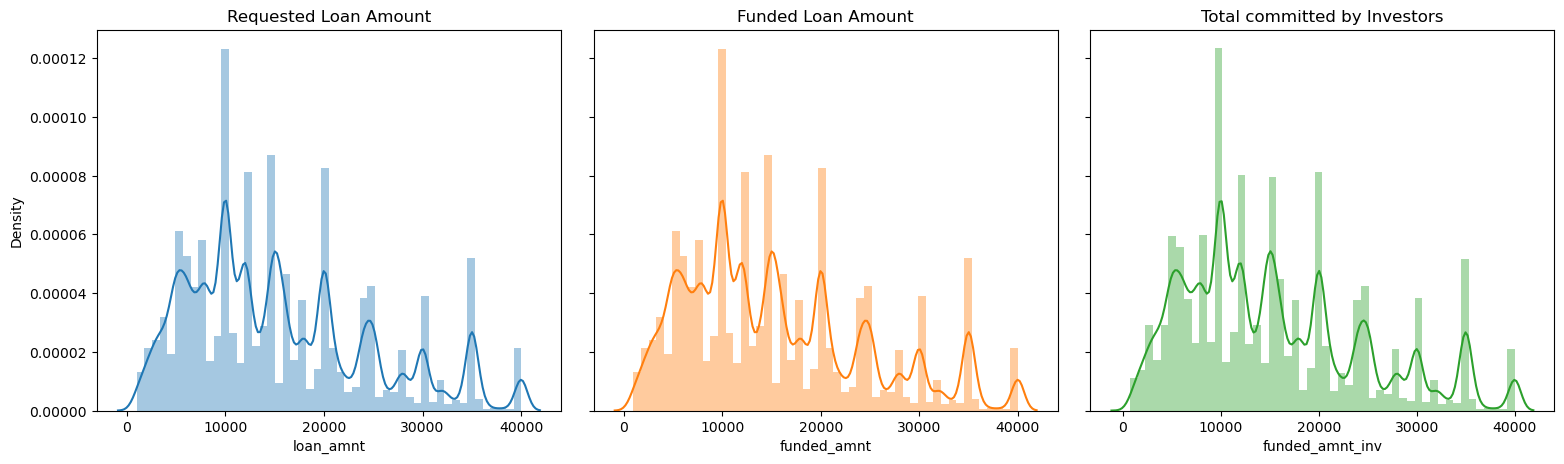

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

sns.distplot(df_reduced["loan_amnt"], ax=ax[0], color=palette_plt[0])
sns.distplot(df_reduced["funded_amnt"], ax=ax[1], color=palette_plt[1])
sns.distplot(df_reduced["funded_amnt_inv"], ax=ax[2], color=palette_plt[2])

ax[0].set_title("Requested Loan Amount")
ax[1].set_title("Funded Loan Amount")
ax[2].set_title("Total committed by Investors")

plt.tight_layout(pad=2);

The first 2 plots present very similar distribution. The 3rd presents some changes, but follows the same trends as the first two. This highlights that in the accepted dataframe the requested amounts were provided to the borowers.

Let's check if some trend can be found over the years.

In [15]:
df_reduced["year"] = pd.to_datetime(df_reduced["issue_d"]).dt.year

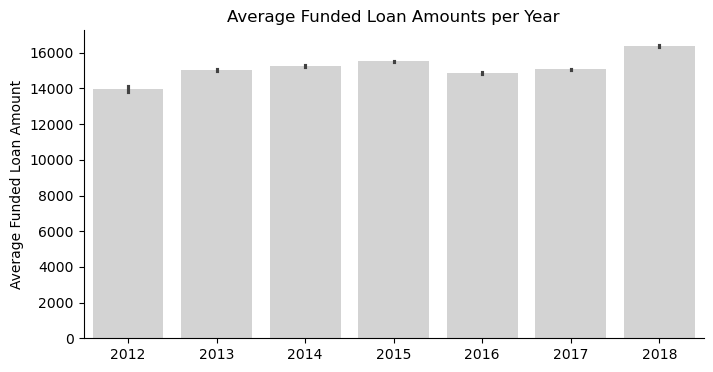

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(data=df_reduced, x='year', y='funded_amnt', ax=ax, color="lightgrey")
ax.set(xlabel="", ylabel="Average Funded Loan Amount", title="Average Funded Loan Amounts per Year")
sns.despine()

2015 and 2018 were the years with the highest average funded loan amounts. 

<h3 style="color:#484E6E">Interest Rate and Annual Income</h3>

How is the interest rate distributed?

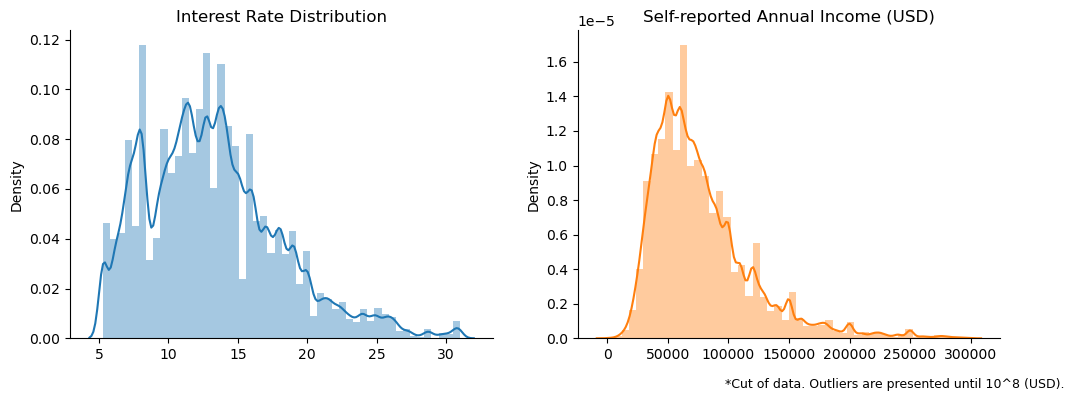

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df_reduced["int_rate"], ax=ax[0], color=palette_plt[0])
ax[0].set(xlabel="", ylabel="Density", title="Interest Rate Distribution")

sns.distplot(df_reduced[df_reduced["annual_inc"]<300_000]["annual_inc"], ax=ax[1], color=palette_plt[1])
ax[1].set(xlabel="", ylabel="Density", title="Self-reported Annual Income (USD)")
ax[1].text(0.75, -0.15, "*Cut of data. Outliers are presented until 10^8 (USD).", transform=ax[1].transAxes, fontsize=9, ha='center', va='center')

sns.despine()

We see that the interest rate ranges from 5 to slightly above 30. We will further evaluate this feature in relation to others in the next sections.

The Annual income ranges specially from 0 to 300_000 USD with median around 70_000 USD.

<h3 style="color:#484E6E">Loan Grade</h3>

A loan grade is a rating or classification assigned to a loan based on the borrower's creditworthiness, indicating the level of risk associated with the loan. It helps lenders assess the likelihood of repayment.

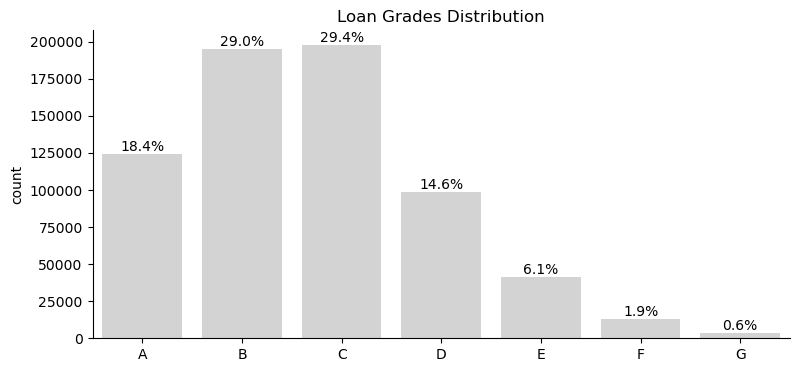

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.countplot(data=df_reduced, x='grade', order=sorted(df_reduced['grade'].unique()), color="lightgrey")

total = len(df_reduced['grade'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 2000,
            f'{height/total:.1%}', ha="center")


ax.set(xlabel="", ylabel="count", title="Loan Grades Distribution")
sns.despine()

The above shows that most of the borrower's are classified in B and C (about 60% of the data).

Let's see the interaction of these grades with other features, i.e. funded amount and interest rate.

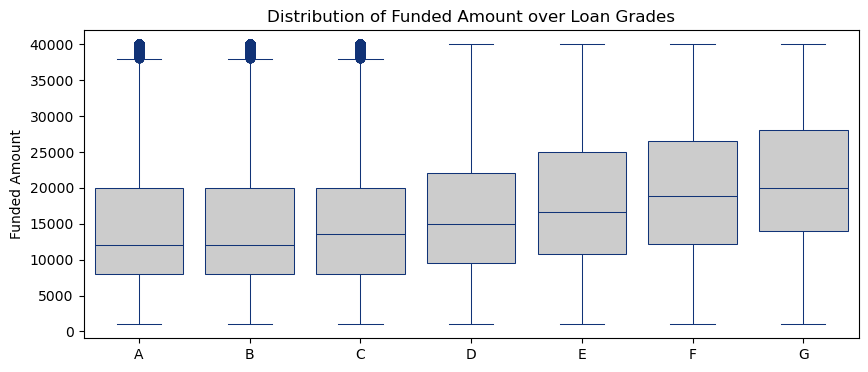

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(
    data=df_reduced,
    x="grade",
    y="funded_amnt",
    order=sorted(df_reduced["grade"].unique()),
    color=".8",
    linecolor="#137",
    linewidth=0.75,
    ax=ax,
)
ax.set(xlabel="", ylabel="Funded Amount", title="Distribution of Funded Amount over Loan Grades");

We see a tendency for higher funded amounts to end up in class E, F and G (higher median funded amount in these classes). There are however many outliers in Class A, B and C.

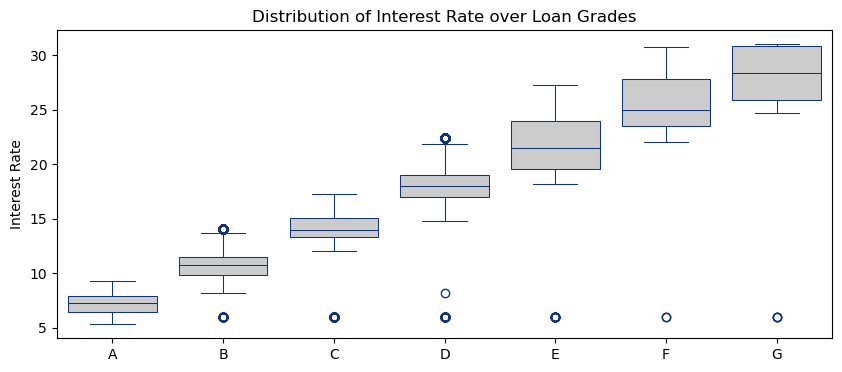

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(
    data=df_reduced,
    x="grade",
    y="int_rate",
    order=sorted(df_reduced["grade"].unique()),
    color=".8",
    linecolor="#137",
    linewidth=0.75,
    ax=ax,
)
ax.set(
    xlabel="",
    ylabel="Interest Rate",
    title="Distribution of Interest Rate over Loan Grades",
);

We can see that the interest rates of loans in the Lending Club are applied according to the Loan Grade. The higher the risk the higher the interest rate.

The outliers in the plot, shows us however that this is not the only parameter taken into consideration for the interest rate.

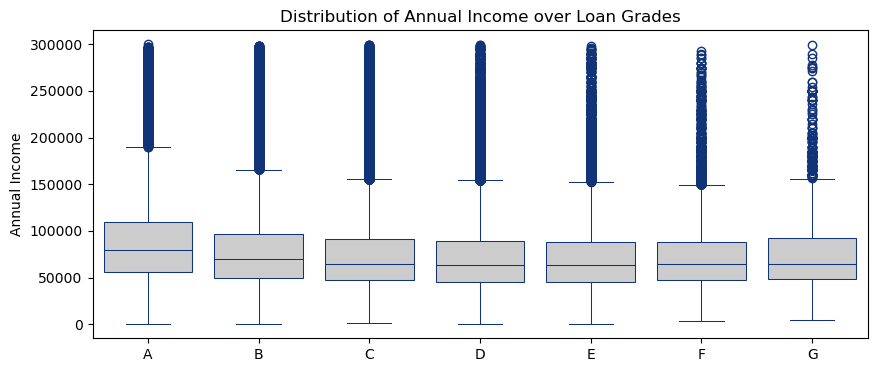

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(
    data=df_reduced[df_reduced["annual_inc"] < 300_000],
    x="grade",
    y="annual_inc",
    order=sorted(df_reduced["grade"].unique()),
    color=".8",
    linecolor="#137",
    linewidth=0.75,
    ax=ax,
)
ax.set(
    xlabel="",
    ylabel="Annual Income",
    title="Distribution of Annual Income over Loan Grades",
);

There is hardly a pattern to see in these distributions, the median income for grades A and B is slightly higher than for the other classes.

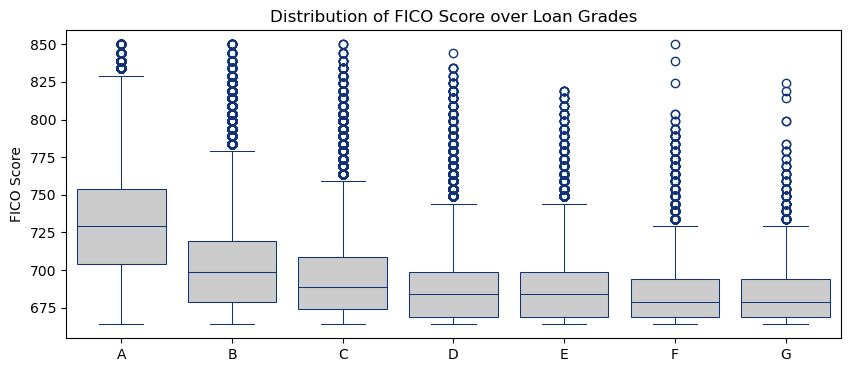

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(
    data=df_reduced,
    x="grade",
    y="fico_range_high",
    order=sorted(df_reduced["grade"].unique()),
    color=".8",
    linecolor="#137",
    linewidth=0.75,
    ax=ax,
)
ax.set(
    xlabel="",
    ylabel="FICO Score",
    title="Distribution of FICO Score over Loan Grades",
);

Here it is clear that people/instituions in Grade A tend to have higher FICO Scores.

<h3 style="color:#484E6E">Loan Subgrade</h3>

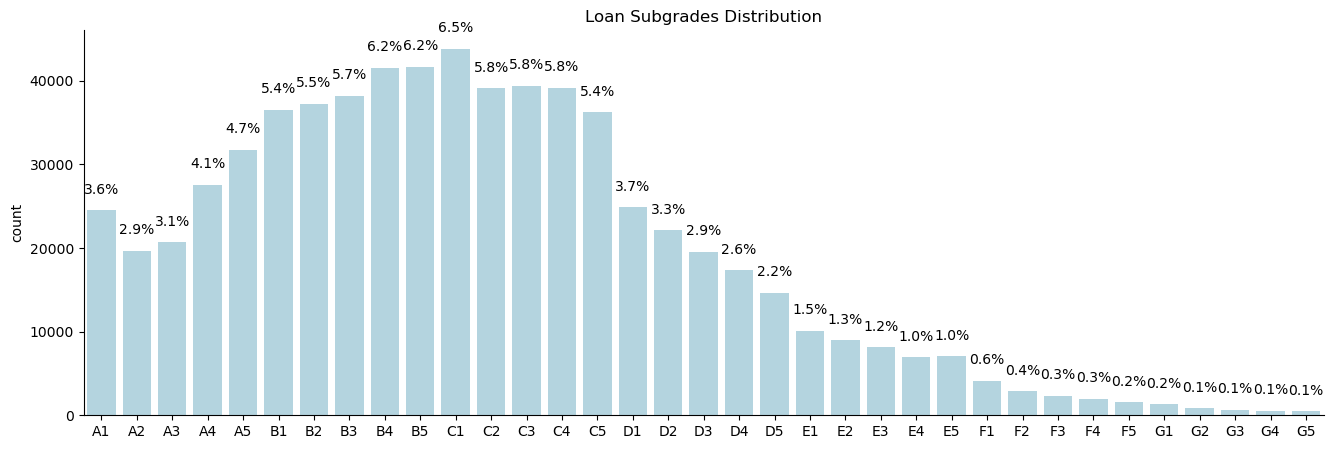

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
sns.countplot(data=df_reduced, x='sub_grade', order=sorted(df_reduced['sub_grade'].unique()), color="lightblue")

total = len(df_reduced['sub_grade'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 2000,
            f'{height/total:.1%}', ha="center")


ax.set(xlabel="", ylabel="count", title="Loan Subgrades Distribution")
sns.despine()

The subgrades range from 1 to 5 for each one of the correspondent grades. We can see again, most of the loans in the grades B and C, the major subgrade being C1.

<h2 style="color:#484E6E">Thresholding Numerical Feature Variance</h2>

Let's redefine our num and cat features.

In [24]:
num_feats = df_reduced.select_dtypes(include='number').columns
cat_feats = df_reduced.select_dtypes(include='object').columns

print(f"Shape of num_features: {df_reduced[num_feats].shape[1]}")

Shape of num_features: 69


The variance threshold represents the minimum amount of variability you want in your numerical features to be considered informative. Removing numerical features with low variance is beneficial for simplifying and improving machine learning models by reducing noise and computational complexity. It helps focus on more informative features, potentially enhancing model interpretability and generalization performance.

Before, we quickly run our data through a robust scaler, to make the best use of our thresholding of features.

In [25]:
scaler = RobustScaler()
df_num_scaled = scaler.fit_transform(df_reduced[num_feats])

thresholder = VarianceThreshold(threshold=0.5)
features_high_variance = thresholder.fit_transform(df_num_scaled)
selected_features = df_reduced[num_feats].columns[thresholder.get_support()]

len(selected_features)

55

In [26]:
print("List of removed features:")
set(num_feats) - set(selected_features)

List of removed features:


{'acc_now_delinq',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'mort_acc',
 'mths_since_recent_inq',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'percent_bc_gt_75',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_util',
 'tax_liens'}

Through this process only a few features were removed (14 using a Threshold of 0.5), highlighting that most of them present a high variability and can convey good information. We will keep these features further in our numerical set.

In [27]:
features = selected_features.append(cat_feats)
df_reduced = df_reduced[features]

<h2 style="color:#484E6E">Correlation of Features</h2>

Let's see if the numerical features correlate to each other. Due to the large number of columns, we divide our presentation in 2 plots. It is clear that by doing that we will not see how all the features relate to each other, though a good overview can already be made. Besides, we will already check how one of our target features (int_rate) relate to the others.

In [28]:
num_feats = df_reduced.select_dtypes(include='number').columns
cat_feats = df_reduced.select_dtypes(include='object').columns

print(f"Shape of num_features: {df_reduced[num_feats].shape[1]}")

Shape of num_features: 55


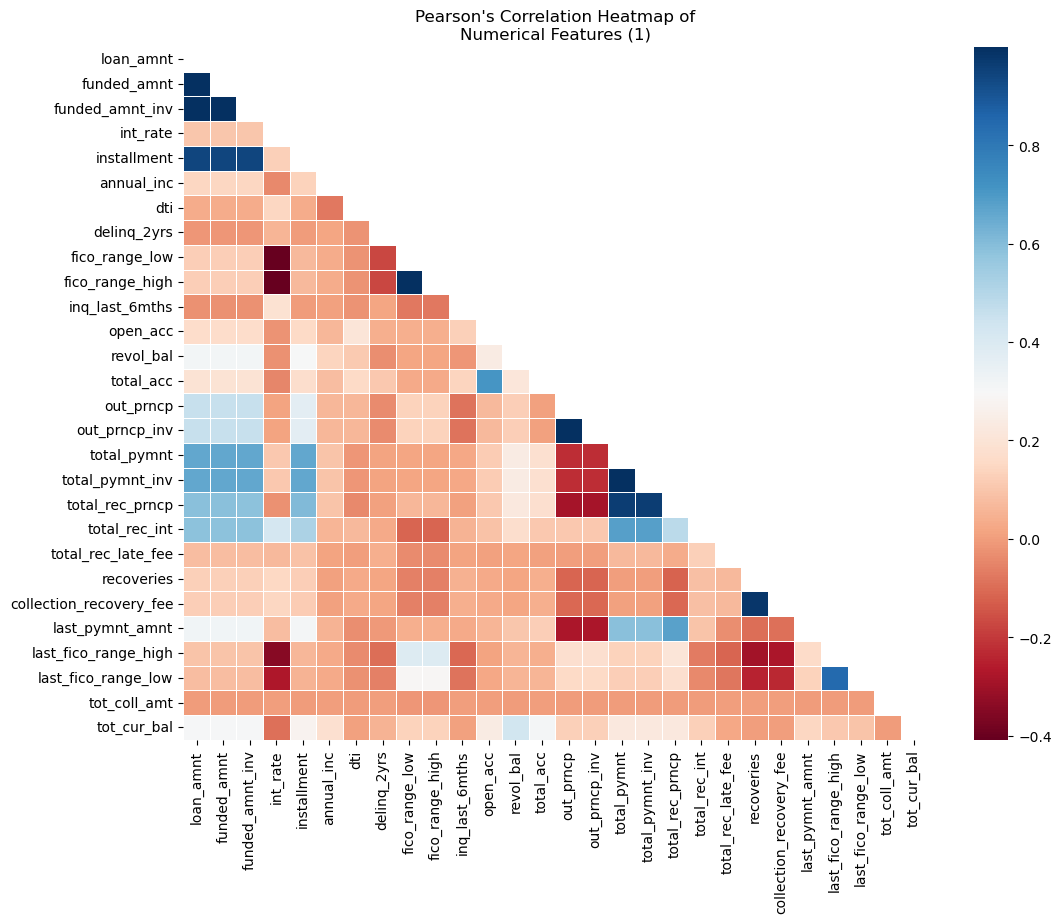

In [29]:
matrix = np.triu(df_reduced[num_feats[:28]].corr())

plt.figure(figsize=(12, 9))
sns.heatmap(df_reduced[num_feats[:28]].corr(), annot=False, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Pearson's Correlation Heatmap of\nNumerical Features (1)");

Most features in this Accepted Dataset show no correlation, we see however some predominantly positive correlation between:
- funded_amnt, funded_amnt_inv and installment, total_pymnt, total_pymnt_inv.
- out_prncp, out_prncp_inv (remaining principal).
- collection_recovery_fee, recoveries.

Negative correlations between:
- Int_rate and FICO scores (fico_range_high, fico_range_low, last_fico_range_high, last_fico_range_low).
- revol_util and FICO	(Revolving line utilization rate)
- out_prncp, out_prncp_inv (remaining principal) to payments.

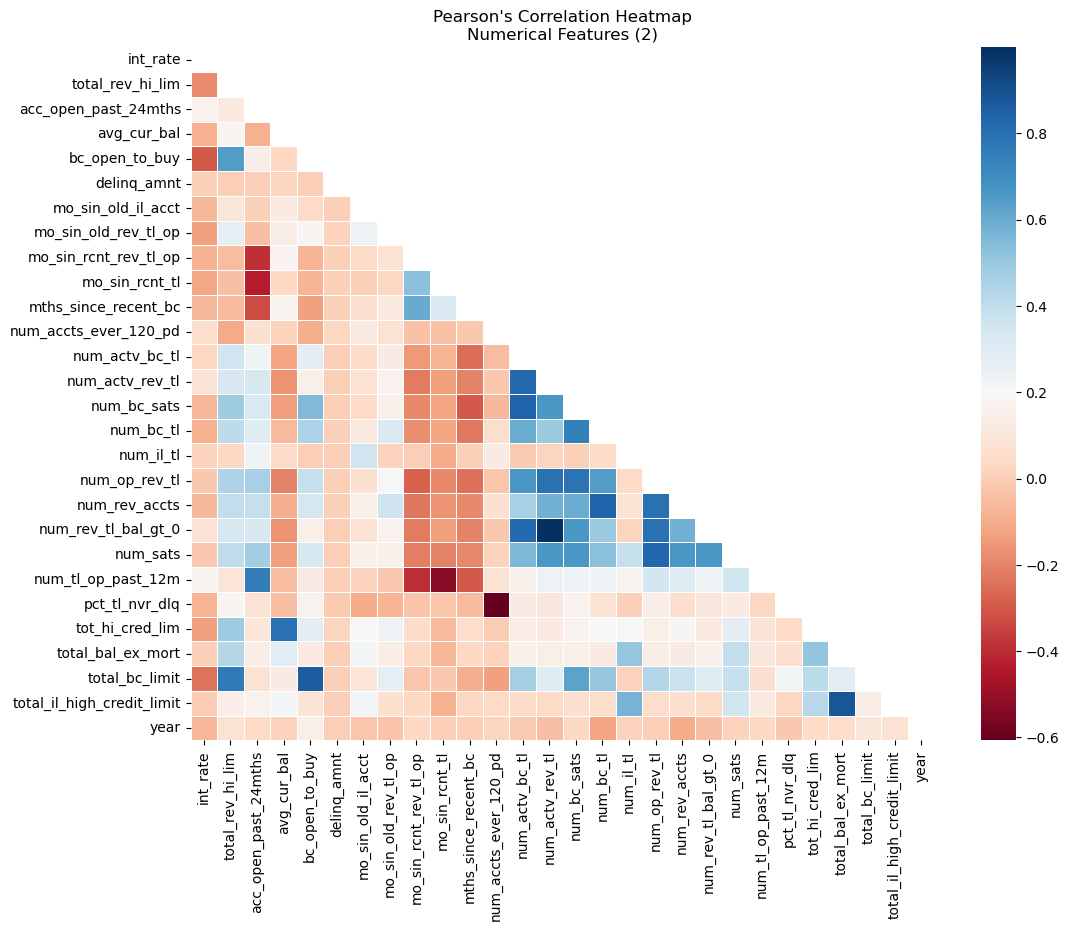

In [30]:
matrix = np.triu(df_reduced[num_feats[28:].insert(0, "int_rate")].corr())

plt.figure(figsize=(12, 9))
sns.heatmap(df_reduced[num_feats[28:].insert(0, "int_rate")].corr(), annot=False, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Pearson's Correlation Heatmap\nNumerical Features (2)");

For this part of the numeric features, our interest rate has less features considered to be correlated.
Furthermore, some positive correlations can be found specially around the number of revolving accounts.

<h2 style="color:#484E6E">Univariate Feature Importance</h2>

Let's **find out the features that have most importance for each of the target** variables. 

<h3 style="color:#484E6E">Loan Grade / Subgrade </h3>

In [31]:
encoder = LabelEncoder()
df_obj_enc = (
    df_reduced.select_dtypes("object")
    .apply(encoder.fit_transform)
)

target = df_obj_enc["grade"]
df_num = df_reduced.select_dtypes("number")

In [32]:
X = df_obj_enc.drop("grade", axis=1)
y = target

bestfeature_obj = SelectKBest(score_func=chi2, k="all")
bf_obj = bestfeature_obj.fit(X, y)

bestfeature_num = SelectKBest(score_func=f_classif, k="all")
bf_num = bestfeature_num.fit(df_num, y)

In [33]:
score = pd.concat([pd.DataFrame(bf_obj.scores_), pd.DataFrame(bf_num.scores_)], axis=0)
colnames = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(df_num.columns)], axis=0)
bf_result = pd.concat([colnames, score], axis='columns')
bf_result.columns = ['Feature','Score']
bf_result.nlargest(25,'Score')

,Feature,Score
1,sub_grade,2434743.924
3,int_rate,1167779.224
0,term,72859.263
8,fico_range_low,33068.381
9,fico_range_high,33067.813
19,total_rec_int,29619.764
4,verification_status,26663.159
24,last_fico_range_high,18236.973
16,disbursement_method,17568.992
31,bc_open_to_buy,15938.819


This tool highlights how related sub_grade and int_rate are to the grade (as also shown before).

Some other features that seem to be related are: term, FICO values, etc.

<h3 style="color:#484E6E">Interest Rate</h3>

In [34]:
df_enc = df_obj_enc.merge(df_num, left_index=True, right_index=True)
target = df_enc["int_rate"]

bestfeature = SelectKBest(score_func=f_regression, k="all")
bf = bestfeature.fit(df_enc.drop("int_rate", axis=1), target)

In [35]:
score = pd.DataFrame(bf_obj.scores_)
colnames = pd.DataFrame(df_enc.columns)

bf_result = pd.concat([colnames, score], axis='columns')
bf_result.columns = ['Feature','Score']
bf_result.nlargest(20,'Score')

,Feature,Score
1,grade,2434743.924
0,term,72859.263
4,home_ownership,26663.159
16,hardship_flag,17568.992
8,pymnt_plan,13304.488
3,emp_length,6728.061
6,issue_d,4557.319
11,earliest_cr_line,4233.279
12,initial_list_status,4087.589
10,addr_state,3240.922


The above shows us that some features (most of them) presented null values from this f_regression evaluation. It is not so clear to me why this happened.

The current features' names will be exported and will we run them through a preprocessing pipeline in the next notebook.

In [36]:
df_reduced.select_dtypes("object").nunique()

term                      2
grade                     7
sub_grade                35
emp_length               11
home_ownership            6
verification_status       3
issue_d                  77
loan_status               7
pymnt_plan                2
purpose                  13
addr_state               51
earliest_cr_line        706
initial_list_status       2
last_pymnt_d             79
last_credit_pull_d       79
application_type          2
hardship_flag             2
disbursement_method       2
debt_settlement_flag      2
dtype: int64

In [37]:
no_variability_cat_feats = ['hardship_flag', 'pymnt_plan']
high_card_feats = ['addr_state', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'year', 'purpose', ]

remaining_feats = df_reduced.columns.difference(no_variability_cat_feats + high_card_feats)

In [38]:
#np.savetxt("data/exported/accepted_columns.txt", remaining_feats, fmt="%s")